# QC Multi-Run Analysis

This notebook analyzes quality control methods with multi-run support.

In [1]:
from pathlib import Path
import sys


SRC_ROOT = Path(".." ).resolve()
PROJECT_ROOT = SRC_ROOT.parent
if str(SRC_ROOT) not in sys.path:
    sys.path.append(str(SRC_ROOT))
from eval_utils import EvalDataConfig, ResultInventory
from eval_utils import load_method_payloads
from model.calibration.thresholding import ThresholdCalibrator
PROJECT_ROOT


PosixPath('/root/workspace/repos/QualityControl')

In [12]:
data_splits = {
    'mnmv2': ['scanner-symphonytim', 'pathology-norm-vs-fall-scanners-all'], 
    'pmri': ['threet-to-onepointfivet', 'promise12']
}

methods = [
    'score-agreement',
    'location_mse',
    # 'concentration_beta',
    # 'location_beta',
    'location+concentration_beta',
    'beta',
    # 'location_betahomoscedastic',
    'mahalanobis_single',
    'comp_entropy_ensemble'
]

In [13]:
# Load and cache all data for specified datasets, splits, and methods
from collections import defaultdict
import torch
import numpy as np

# Initialize data cache
# Structure: data_cache[dataset][split][method] = {payload, calibrator (if applicable)}
data_cache = defaultdict(lambda: defaultdict(dict))

print("="*100)
print("LOADING DATA FOR ALL DATASETS, SPLITS, AND METHODS")
print("="*100)

for dataset_id, splits in data_splits.items():
    print(f"\nDataset: {dataset_id}")
    print("-"*100)
    
    for split_id in splits:
        print(f"  Split: {split_id}")
        
        # Create configuration for this dataset/split combination
        cfg_temp = EvalDataConfig(
            dataset_id=dataset_id,
            split_id=split_id,
            metric_id="dice",
            calibration_source="val",
            neural_root=PROJECT_ROOT / "results" / "isbi_result",
            score_agreement_root=PROJECT_ROOT / "results" / "isbi_result" / "score-agreement",
            mahalanobis_root=PROJECT_ROOT / "results" / "isbi_result" / "mahalanobis_single",
            entropy_root=PROJECT_ROOT / "results" / "isbi_result" / "comp_entropy_ensemble",
            run_aggregation="all",  # Load all runs for aggregation later
        )
        
        inventory_temp = ResultInventory(cfg_temp)
        method_map_temp = inventory_temp.available_method_labels()
        
        # Filter to only the methods we want (including all runs)
        # Method names will be like: 'score-agreement_run0', 'location_mse_run1', etc.
        filtered_methods = {}
        for k, v in method_map_temp.items():
            # Extract base method name (remove _runX suffix if present)
            base_method = k.rsplit('_run', 1)[0] if '_run' in k else k
            if base_method in methods:
                filtered_methods[k] = v
        
        if not filtered_methods:
            print(f"    ⚠ No matching methods found (available: {list(method_map_temp.keys())})")
            continue
        
        # Load payloads for filtered methods
        method_payloads_temp = load_method_payloads(inventory_temp, cfg_temp)
        
        # Cache each method's data (including all runs)
        for method_label_with_run in filtered_methods.keys():
            if method_label_with_run not in method_payloads_temp:
                print(f"    ✗ {method_label_with_run}: Not found")
                continue
            
            payload = method_payloads_temp[method_label_with_run]
            
            # Store the payload with the full label (including _runX suffix)
            data_cache[dataset_id][split_id][method_label_with_run] = {
                'payload': payload,
                'descriptor': filtered_methods[method_label_with_run],
                'calibrator': None  # Will be populated if needed
            }
            
            # Get data summary
            # test_data = payload['sections'].get('test', {})
            # if 'true_score' in test_data:
            #     n_samples = len(_to_flat_numpy(test_data['true_score']))
            # elif 'scores' in test_data and 'dice' in test_data['scores']:
            #     n_samples = len(_to_flat_numpy(test_data['scores']['dice']))
            # else:
            #     n_samples = 0
            
            # print(f"    ✓ {method_label_with_run}: {n_samples} test samples")

print("\n" + "="*100)
print("DATA LOADING COMPLETE")
print("="*100)

# Summary statistics
total_combinations = 0
loaded_combinations = 0

for dataset_id in data_splits.keys():
    for split_id in data_splits[dataset_id]:
        for method_label_with_run in data_cache[dataset_id][split_id].keys():
            total_combinations += 1
            loaded_combinations += 1

print(f"\nLoaded {loaded_combinations} dataset/split/method/run combinations")
print(f"Datasets: {list(data_splits.keys())}")
print(f"Base methods: {methods}")

# Show cache structure with run counts
print(f"\nCache structure (with run counts):")
for dataset_id in sorted(data_cache.keys()):
    print(f"  {dataset_id}:")
    for split_id in sorted(data_cache[dataset_id].keys()):
        method_list = list(data_cache[dataset_id][split_id].keys())
        
        # Group by base method to show run counts
        from collections import defaultdict
        base_method_runs = defaultdict(list)
        for method_full in method_list:
            if '_run' in method_full:
                base = method_full.rsplit('_run', 1)[0]
                run_num = int(method_full.rsplit('_run', 1)[1])
                base_method_runs[base].append(run_num)
            else:
                base_method_runs[method_full].append(None)
        
        print(f"    {split_id}:")
        for base, runs in sorted(base_method_runs.items()):
            if None in runs:
                print(f"      {base}: 1 run (no iterator)")
            else:
                print(f"      {base}: {len(runs)} runs → {sorted(runs)}")

LOADING DATA FOR ALL DATASETS, SPLITS, AND METHODS

Dataset: mnmv2
----------------------------------------------------------------------------------------------------
  Split: scanner-symphonytim
  Split: pathology-norm-vs-fall-scanners-all

Dataset: pmri
----------------------------------------------------------------------------------------------------
  Split: threet-to-onepointfivet
  Split: promise12

DATA LOADING COMPLETE

Loaded 104 dataset/split/method/run combinations
Datasets: ['mnmv2', 'pmri']
Base methods: ['score-agreement', 'location_mse', 'location+concentration_beta', 'beta', 'mahalanobis_single', 'comp_entropy_ensemble']

Cache structure (with run counts):
  mnmv2:
    pathology-norm-vs-fall-scanners-all:
      beta: 5 runs → [0, 1, 2, 3, 4]
      comp_entropy_ensemble: 5 runs → [1, 2, 3, 4, 5]
      location+concentration_beta: 5 runs → [0, 1, 2, 3, 4]
      location_mse: 5 runs → [0, 1, 2, 3, 4]
      mahalanobis_single: 1 runs → [1]
      score-agreement: 5 runs → 

In [14]:
# Fit and cache calibrators for all methods across all datasets/splits
from model.calibration.distributions import BetaAdapter

# Initialize a single BetaAdapter (shared across all beta methods)
beta_adapter = BetaAdapter()

print("="*100)
print("FITTING CALIBRATORS FOR ALL METHODS")
print("="*100)

for dataset_id in sorted(data_cache.keys()):
    print(f"\nDataset: {dataset_id}")
    print("-"*100)
    
    for split_id in sorted(data_cache[dataset_id].keys()):
        print(f"  Split: {split_id}")
        
        for method_label_with_run, cached_data in data_cache[dataset_id][split_id].items():
            payload = cached_data['payload']
            descriptor = cached_data['descriptor']
            variant = payload.get('variant', '')
            source = payload['source']
            
            # Determine which calibrator to use
            if source in ['score_agreement', 'mahalanobis', 'entropy']:
                # Fit ThresholdCalibrator for correlate-based methods
                # For score-agreement: dice_agreement is PREDICTION, dice is GROUND TRUTH
                # For mahalanobis: mahalanobis is PREDICTION, dice is GROUND TRUTH
                # For entropy: entropy is PREDICTION, dice is GROUND TRUTH
                val_data = payload['sections']['val']
                
                if source == 'score_agreement':
                    y_pred = val_data['scores']['dice_agreement']
                elif source == 'mahalanobis':
                    y_pred = val_data['scores']['mahalanobis']
                elif source == 'entropy':
                    y_pred = val_data['scores']['entropy']
                
                y_true = val_data['scores']['dice']
                
                calibrator = ThresholdCalibrator(higher_is_better=True)
                calibrator.fit(y_pred, y_true)
                cached_data['calibrator'] = calibrator
                print(f"    ✓ {method_label_with_run}: ThresholdCalibrator fitted")
                
            elif variant == 'mse' or variant == 'betahomoscedastic':
                # Fit ThresholdCalibrator for MSE-based neural methods
                # AND location_betahomoscedastic (homoscedastic = kappa not learned, needs calibration)
                val_data = payload['sections']['val']
                y_pred = val_data['predicted_score']
                y_true = val_data['true_score']
                
                calibrator = ThresholdCalibrator(higher_is_better=True)
                calibrator.fit(y_pred, y_true)
                cached_data['calibrator'] = calibrator
                print(f"    ✓ {method_label_with_run}: ThresholdCalibrator fitted")
                
            elif 'beta' in variant.lower() or source == 'neural':
                # Use BetaAdapter for beta-based methods (including plain 'beta')
                # Excludes betahomoscedastic (handled above)
                # No fitting needed - just store reference to shared adapter
                cached_data['calibrator'] = beta_adapter
                print(f"    ✓ {method_label_with_run}: BetaAdapter assigned")
                
            else:
                print(f"    ⚠ {method_label_with_run}: No calibrator needed (variant={variant}, source={source})")

print("\n" + "="*100)
print("CALIBRATOR FITTING COMPLETE")
print("="*100)

# Summary
total_threshold = 0
total_beta = 0
total_none = 0

for dataset_id in data_cache.keys():
    for split_id in data_cache[dataset_id].keys():
        for method_label_with_run, cached_data in data_cache[dataset_id][split_id].items():
            calibrator = cached_data['calibrator']
            if isinstance(calibrator, ThresholdCalibrator):
                total_threshold += 1
            elif isinstance(calibrator, BetaAdapter):
                total_beta += 1
            else:
                total_none += 1

print(f"\nCalibrator Summary:")
print(f"  ThresholdCalibrators: {total_threshold}")
print(f"  BetaAdapters: {total_beta}")
print(f"  No calibrator: {total_none}")
print(f"  Total methods: {total_threshold + total_beta + total_none}")

FITTING CALIBRATORS FOR ALL METHODS

Dataset: mnmv2
----------------------------------------------------------------------------------------------------
  Split: pathology-norm-vs-fall-scanners-all
[ThresholdCalibrator] Fitted on 128 points.
    ✓ score-agreement_run0: ThresholdCalibrator fitted
[ThresholdCalibrator] Fitted on 128 points.
    ✓ score-agreement_run1: ThresholdCalibrator fitted
[ThresholdCalibrator] Fitted on 128 points.
    ✓ score-agreement_run2: ThresholdCalibrator fitted
[ThresholdCalibrator] Fitted on 128 points.
    ✓ score-agreement_run3: ThresholdCalibrator fitted
[ThresholdCalibrator] Fitted on 128 points.
    ✓ score-agreement_run4: ThresholdCalibrator fitted
[ThresholdCalibrator] Fitted on 128 points.
    ✓ mahalanobis_single_run1: ThresholdCalibrator fitted
[ThresholdCalibrator] Fitted on 128 points.
    ✓ comp_entropy_ensemble_run1: ThresholdCalibrator fitted
[ThresholdCalibrator] Fitted on 128 points.
    ✓ comp_entropy_ensemble_run2: ThresholdCalibrator fi

In [15]:
# Comparative Analysis: All Methods Across All Splits
import torch
import numpy as np
import pandas as pd

# Configuration
DICE_THRESHOLD = 0.80
CONFIDENCE_LEVEL = 0.95
RISK_CUTOFF = 1.0 - CONFIDENCE_LEVEL

print("="*100)
print(f"COMPARATIVE RECALL METRICS: ALL METHODS")
print(f"Dice Threshold: {DICE_THRESHOLD} | Confidence Level: {CONFIDENCE_LEVEL}")
print("="*100)

# Collect results for each dataset/split
for dataset_id in sorted(data_cache.keys()):
    print(f"\n{'='*100}")
    print(f"Dataset: {dataset_id}")
    print(f"{'='*100}")
    
    for split_id in sorted(data_cache[dataset_id].keys()):
        print(f"\nSplit: {split_id}")
        print("-"*100)
        
        # Collect results grouped by method type
        method_results = {}
        
        # Process all methods in this split
        for method_label, cached_data in sorted(data_cache[dataset_id][split_id].items()):
            payload = cached_data['payload']
            calibrator = cached_data['calibrator']
            test_data = payload['sections']['test']
            source = payload['source']
            variant = payload.get('variant', '')
            
            # Determine base method name
            if 'score-agreement' in method_label:
                base_method = 'score-agreement'
            elif 'mahalanobis' in method_label:
                base_method = 'mahalanobis_single'
            elif 'comp_entropy' in method_label:
                base_method = 'comp_entropy_ensemble'
            elif 'location_mse' in method_label:
                base_method = 'location_mse'
            elif 'location+concentration_beta' in method_label:
                base_method = 'location+concentration_beta'
            elif 'location_betahomoscedastic' in method_label:
                base_method = 'location_betahomoscedastic'
            elif 'location_beta' in method_label:
                base_method = 'location_beta'
            elif 'concentration_beta' in method_label:
                base_method = 'concentration_beta'
            elif method_label.startswith('beta'):
                base_method = 'beta'
            else:
                continue  # Skip other methods
            
            # Initialize results list for this base method
            if base_method not in method_results:
                method_results[base_method] = []
            
            # Get ground truth
            if source in ['score_agreement', 'mahalanobis', 'entropy']:
                y_true_score = test_data['scores']['dice']
            else:
                y_true_score = test_data['true_score']
            
            if y_true_score.dim() > 1:
                y_true_score = y_true_score.squeeze(-1)
            
            # Bad case mask
            y_true_bad_mask = (y_true_score < DICE_THRESHOLD)
            total_cases = y_true_score.size(0)
            total_bad = int(y_true_bad_mask.sum().item())
            total_good = total_cases - total_bad
            
            # Compute P(score < threshold) using appropriate calibrator
            if source == 'score_agreement':
                # Score-agreement: use ThresholdCalibrator with dice_agreement (prediction)
                y_pred = test_data['scores']['dice_agreement']
                if y_pred.dim() > 1:
                    y_pred = y_pred.squeeze(-1)
                proba_bad = calibrator.cdf_tau(y_pred, DICE_THRESHOLD, target_recall_bad=CONFIDENCE_LEVEL)
                proba_bad = torch.as_tensor(proba_bad)
                
            elif source == 'mahalanobis':
                # Mahalanobis: use ThresholdCalibrator with mahalanobis (prediction)
                y_pred = test_data['scores']['mahalanobis']
                if y_pred.dim() > 1:
                    y_pred = y_pred.squeeze(-1)
                proba_bad = calibrator.cdf_tau(y_pred, DICE_THRESHOLD, target_recall_bad=CONFIDENCE_LEVEL)
                proba_bad = torch.as_tensor(proba_bad)
                
            elif source == 'entropy':
                # Entropy: use ThresholdCalibrator with entropy (prediction)
                y_pred = test_data['scores']['entropy']
                if y_pred.dim() > 1:
                    y_pred = y_pred.squeeze(-1)
                proba_bad = calibrator.cdf_tau(y_pred, DICE_THRESHOLD, target_recall_bad=CONFIDENCE_LEVEL)
                proba_bad = torch.as_tensor(proba_bad)
                
            elif variant == 'mse' or variant == 'betahomoscedastic':
                # Location_mse OR location_betahomoscedastic: use ThresholdCalibrator
                y_pred = test_data['predicted_score']
                if y_pred.dim() > 1:
                    y_pred = y_pred.squeeze(-1)
                proba_bad = calibrator.cdf_tau(y_pred, DICE_THRESHOLD, target_recall_bad=CONFIDENCE_LEVEL)
                proba_bad = torch.as_tensor(proba_bad)
                
            elif 'beta' in variant.lower():
                # Beta methods (excluding betahomoscedastic): use BetaAdapter
                mu = test_data['mu']
                kappa = test_data['kappa']
                
                if mu.size(1) > 1:
                    mu = mu[:, 0]
                    kappa = kappa[:, 0]
                
                proba_bad = calibrator.cdf(
                    torch.full_like(mu, DICE_THRESHOLD),
                    mu,
                    kappa
                )
            else:
                continue
            
            # Ensure proba_bad is 1D
            if proba_bad.dim() > 1:
                proba_bad = proba_bad.squeeze(-1)
            
            # Flag as bad if P(bad) > risk_cutoff
            y_pred_bad_mask = (proba_bad > RISK_CUTOFF)
            
            # Compute confusion matrix
            tp = int((y_pred_bad_mask & y_true_bad_mask).sum().item())
            fp = int((y_pred_bad_mask & ~y_true_bad_mask).sum().item())
            fn = int((~y_pred_bad_mask & y_true_bad_mask).sum().item())
            tn = int((~y_pred_bad_mask & ~y_true_bad_mask).sum().item())
            
            # Compute recalls
            rec_good = tn / total_good if total_good > 0 else 0.0
            rec_bad = tp / (tp + fn) if (tp + fn) > 0 else 0.0
            
            # Store results
            method_results[base_method].append({
                'rec_good': rec_good,
                'rec_bad': rec_bad,
                'total_cases': total_cases,
                'total_bad': total_bad,
                'total_good': total_good
            })
        
        # Create comparison table
        if method_results:
            comparison_data = []
            
            for method_name in ['score-agreement', 'mahalanobis_single', 'comp_entropy_ensemble', 
                              'location_mse', 'beta', 'location_betahomoscedastic',
                              'location+concentration_beta', 'location_beta', 'concentration_beta']:
                if method_name not in method_results:
                    continue
                
                runs = method_results[method_name]
                rec_good_values = [r['rec_good'] for r in runs]
                rec_bad_values = [r['rec_bad'] for r in runs]
                
                # Get sample info from first run
                total_cases = runs[0]['total_cases']
                total_bad = runs[0]['total_bad']
                total_good = runs[0]['total_good']
                
                comparison_data.append({
                    'Method': method_name,
                    'N_runs': len(runs),
                    'Rec⁺ Mean': np.mean(rec_good_values),
                    'Rec⁺ Std': np.std(rec_good_values, ddof=1) if len(rec_good_values) > 1 else 0.0,
                    'Rec⁻ Mean': np.mean(rec_bad_values),
                    'Rec⁻ Std': np.std(rec_bad_values, ddof=1) if len(rec_bad_values) > 1 else 0.0,
                })
            
            # Display comparison table
            comparison_df = pd.DataFrame(comparison_data)
            
            print(f"\n  Method Comparison:")
            display(comparison_df.style
                .format({
                    'Rec⁺ Mean': '{:.4f}',
                    'Rec⁺ Std': '{:.4f}',
                    'Rec⁻ Mean': '{:.4f}',
                    'Rec⁻ Std': '{:.4f}'
                })
                .background_gradient(subset=['Rec⁺ Mean', 'Rec⁻ Mean'], cmap='RdYlGn', vmin=0, vmax=1)
                .set_properties(**{'text-align': 'center'})
            )
            
            # Print formatted summary
            print(f"\n  Summary (Mean ± Std):")
            for row in comparison_data:
                print(f"    {row['Method']:<35} | "
                      f"Rec⁺: {row['Rec⁺ Mean']:.4f} ± {row['Rec⁺ Std']:.4f} | "
                      f"Rec⁻: {row['Rec⁻ Mean']:.4f} ± {row['Rec⁻ Std']:.4f} | "
                      f"N={row['N_runs']}")

print("\n" + "="*100)
print("COMPARATIVE ANALYSIS COMPLETE")
print("="*100)

COMPARATIVE RECALL METRICS: ALL METHODS
Dice Threshold: 0.8 | Confidence Level: 0.95

Dataset: mnmv2

Split: pathology-norm-vs-fall-scanners-all
----------------------------------------------------------------------------------------------------

  Method Comparison:


,Method,N_runs,Rec⁺ Mean,Rec⁺ Std,Rec⁻ Mean,Rec⁻ Std
0,score-agreement,5,0.6166,0.0699,0.9956,0.0031
1,mahalanobis_single,1,0.0000,0.0000,1.0000,0.0000
2,comp_entropy_ensemble,5,0.0000,0.0000,1.0000,0.0000
3,location_mse,5,0.7072,0.0741,0.9698,0.0152
4,beta,5,0.7309,0.0417,0.8524,0.0442
5,location+concentration_beta,5,0.6950,0.0340,0.9796,0.0081



  Summary (Mean ± Std):
    score-agreement                     | Rec⁺: 0.6166 ± 0.0699 | Rec⁻: 0.9956 ± 0.0031 | N=5
    mahalanobis_single                  | Rec⁺: 0.0000 ± 0.0000 | Rec⁻: 1.0000 ± 0.0000 | N=1
    comp_entropy_ensemble               | Rec⁺: 0.0000 ± 0.0000 | Rec⁻: 1.0000 ± 0.0000 | N=5
    location_mse                        | Rec⁺: 0.7072 ± 0.0741 | Rec⁻: 0.9698 ± 0.0152 | N=5
    beta                                | Rec⁺: 0.7309 ± 0.0417 | Rec⁻: 0.8524 ± 0.0442 | N=5
    location+concentration_beta         | Rec⁺: 0.6950 ± 0.0340 | Rec⁻: 0.9796 ± 0.0081 | N=5

Split: scanner-symphonytim
----------------------------------------------------------------------------------------------------

  Method Comparison:


,Method,N_runs,Rec⁺ Mean,Rec⁺ Std,Rec⁻ Mean,Rec⁻ Std
0,score-agreement,5,0.7922,0.0153,0.9534,0.0066
1,mahalanobis_single,1,0.0832,0.0000,0.9944,0.0000
2,comp_entropy_ensemble,5,0.0124,0.0022,0.9509,0.0090
3,location_mse,5,0.7837,0.0148,0.9543,0.0054
4,beta,5,0.8482,0.0168,0.9018,0.0200
5,location+concentration_beta,5,0.7074,0.0121,0.9615,0.0072



  Summary (Mean ± Std):
    score-agreement                     | Rec⁺: 0.7922 ± 0.0153 | Rec⁻: 0.9534 ± 0.0066 | N=5
    mahalanobis_single                  | Rec⁺: 0.0832 ± 0.0000 | Rec⁻: 0.9944 ± 0.0000 | N=1
    comp_entropy_ensemble               | Rec⁺: 0.0124 ± 0.0022 | Rec⁻: 0.9509 ± 0.0090 | N=5
    location_mse                        | Rec⁺: 0.7837 ± 0.0148 | Rec⁻: 0.9543 ± 0.0054 | N=5
    beta                                | Rec⁺: 0.8482 ± 0.0168 | Rec⁻: 0.9018 ± 0.0200 | N=5
    location+concentration_beta         | Rec⁺: 0.7074 ± 0.0121 | Rec⁻: 0.9615 ± 0.0072 | N=5

Dataset: pmri

Split: promise12
----------------------------------------------------------------------------------------------------

  Method Comparison:


,Method,N_runs,Rec⁺ Mean,Rec⁺ Std,Rec⁻ Mean,Rec⁻ Std
0,score-agreement,5,0.7848,0.0163,0.8520,0.0097
1,mahalanobis_single,1,0.0000,0.0000,1.0000,0.0000
2,comp_entropy_ensemble,5,0.3162,0.0581,0.9568,0.0112
3,location_mse,5,0.4177,0.1057,0.9705,0.0139
4,beta,5,0.7912,0.0213,0.8422,0.0158
5,location+concentration_beta,5,0.4223,0.0299,0.9697,0.0035



  Summary (Mean ± Std):
    score-agreement                     | Rec⁺: 0.7848 ± 0.0163 | Rec⁻: 0.8520 ± 0.0097 | N=5
    mahalanobis_single                  | Rec⁺: 0.0000 ± 0.0000 | Rec⁻: 1.0000 ± 0.0000 | N=1
    comp_entropy_ensemble               | Rec⁺: 0.3162 ± 0.0581 | Rec⁻: 0.9568 ± 0.0112 | N=5
    location_mse                        | Rec⁺: 0.4177 ± 0.1057 | Rec⁻: 0.9705 ± 0.0139 | N=5
    beta                                | Rec⁺: 0.7912 ± 0.0213 | Rec⁻: 0.8422 ± 0.0158 | N=5
    location+concentration_beta         | Rec⁺: 0.4223 ± 0.0299 | Rec⁻: 0.9697 ± 0.0035 | N=5

Split: threet-to-onepointfivet
----------------------------------------------------------------------------------------------------

  Method Comparison:


,Method,N_runs,Rec⁺ Mean,Rec⁺ Std,Rec⁻ Mean,Rec⁻ Std
0,score-agreement,5,0.1090,0.0262,0.9990,0.0022
1,mahalanobis_single,1,0.0000,0.0000,1.0000,0.0000
2,comp_entropy_ensemble,5,0.0780,0.0150,0.9716,0.0041
3,location_mse,5,0.0982,0.0543,0.9971,0.0044
4,beta,5,0.8253,0.0366,0.8461,0.0261
5,location+concentration_beta,5,0.4274,0.0677,0.9814,0.0054



  Summary (Mean ± Std):
    score-agreement                     | Rec⁺: 0.1090 ± 0.0262 | Rec⁻: 0.9990 ± 0.0022 | N=5
    mahalanobis_single                  | Rec⁺: 0.0000 ± 0.0000 | Rec⁻: 1.0000 ± 0.0000 | N=1
    comp_entropy_ensemble               | Rec⁺: 0.0780 ± 0.0150 | Rec⁻: 0.9716 ± 0.0041 | N=5
    location_mse                        | Rec⁺: 0.0982 ± 0.0543 | Rec⁻: 0.9971 ± 0.0044 | N=5
    beta                                | Rec⁺: 0.8253 ± 0.0366 | Rec⁻: 0.8461 ± 0.0261 | N=5
    location+concentration_beta         | Rec⁺: 0.4274 ± 0.0677 | Rec⁻: 0.9814 ± 0.0054 | N=5

COMPARATIVE ANALYSIS COMPLETE


RECALL vs DICE THRESHOLD AT CONFIDENCE = 0.95
Methods to plot: ['score-agreement', 'location_mse', 'location+concentration_beta']


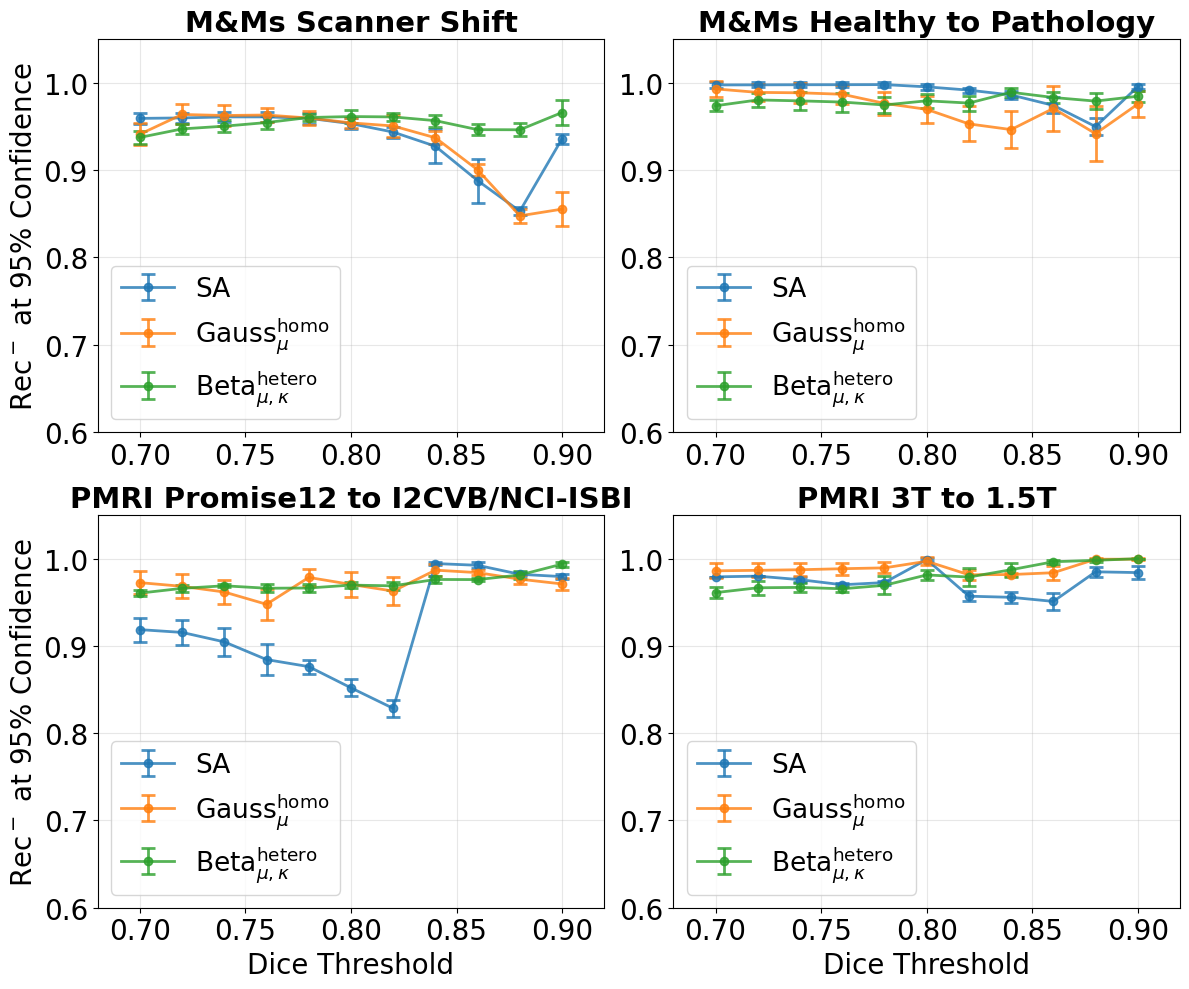

In [20]:
# Plot: Recall of Bad Cases (Rec⁻) vs Dice Threshold at 95% Confidence
# 2x2 plot layout, one subplot per dataset/split, comparing selected methods with error bars
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Configuration
CONFIDENCE_LEVEL = 0.95
RISK_CUTOFF = 1.0 - CONFIDENCE_LEVEL
DICE_THRESHOLDS = np.arange(0.70, 0.91, 0.02)  # Threshold range

# Font size knob - adjust this to scale all text in the plot
FONT_SIZE = 20

# Select methods to plot (subset of all available methods)
# Order determines legend order (top to bottom)
METHODS_TO_PLOT = [
    'score-agreement',
    'location_mse',
    'location+concentration_beta',
    # 'comp_entropy_ensemble'
 ]

# Dataset display names (customize as needed)
DATASET_NAMES = {
    'mnmv2_scanner-symphonytim': 'M&Ms Scanner Shift',
    'mnmv2_pathology-norm-vs-fall-scanners-all': 'M&Ms Healthy to Pathology',
    'pmri_threet-to-onepointfivet': 'PMRI 3T to 1.5T',
    'pmri_promise12': 'PMRI Promise12 to I2CVB/NCI-ISBI'
}

print("="*100)
print(f"RECALL vs DICE THRESHOLD AT CONFIDENCE = {CONFIDENCE_LEVEL}")
print(f"Methods to plot: {METHODS_TO_PLOT}")
print("="*100)

# Collect results for each dataset/split
all_plot_data = {}

for dataset_id in sorted(data_cache.keys()):
    for split_id in sorted(data_cache[dataset_id].keys()):
        plot_key = f"{dataset_id}_{split_id}"
        all_plot_data[plot_key] = {'dataset': dataset_id, 'split': split_id, 'methods': {}}
        
        # For each selected method type
        for base_method in METHODS_TO_PLOT:
            # Find all runs for this method (exact match before _run suffix)
            method_runs = {}
            for label, cached_data in data_cache[dataset_id][split_id].items():
                # Extract base name (remove _runX suffix if present)
                if '_run' in label:
                    label_base = label.rsplit('_run', 1)[0]
                else:
                    label_base = label
                
                # Exact match on base method name
                if label_base == base_method:
                    method_runs[label] = cached_data
            
            if not method_runs:
                continue
            
            # Store recall values across thresholds and runs
            threshold_recalls = {threshold: [] for threshold in DICE_THRESHOLDS}
            
            # Process each run
            for method_label, cached_data in method_runs.items():
                payload = cached_data['payload']
                calibrator = cached_data['calibrator']
                test_data = payload['sections']['test']
                source = payload['source']
                variant = payload.get('variant', '')
                
                # For each dice threshold
                for dice_threshold in DICE_THRESHOLDS:
                    # Get ground truth
                    if source in ['score_agreement', 'mahalanobis', 'entropy']:
                        y_true_score = test_data['scores']['dice']
                    else:
                        y_true_score = test_data['true_score']
                    
                    if y_true_score.dim() > 1:
                        y_true_score = y_true_score.squeeze(-1)
                    
                    # Bad case mask at this threshold
                    y_true_bad_mask = (y_true_score < dice_threshold)
                    total_bad = int(y_true_bad_mask.sum().item())
                    
                    if total_bad == 0:
                        threshold_recalls[dice_threshold].append(np.nan)
                        continue
                    
                    # Compute P(score < threshold) using appropriate calibrator
                    if source == 'score_agreement':
                        y_pred = test_data['scores']['dice_agreement']
                        if y_pred.dim() > 1:
                            y_pred = y_pred.squeeze(-1)
                        proba_bad = calibrator.cdf_tau(y_pred, dice_threshold, target_recall_bad=CONFIDENCE_LEVEL)
                        proba_bad = torch.as_tensor(proba_bad)
                    elif source == 'mahalanobis':
                        y_pred = test_data['scores']['mahalanobis']
                        if y_pred.dim() > 1:
                            y_pred = y_pred.squeeze(-1)
                        proba_bad = calibrator.cdf_tau(y_pred, dice_threshold, target_recall_bad=CONFIDENCE_LEVEL)
                        proba_bad = torch.as_tensor(proba_bad)
                    elif source == 'entropy':
                        y_pred = test_data['scores']['entropy']
                        if y_pred.dim() > 1:
                            y_pred = y_pred.squeeze(-1)
                        proba_bad = calibrator.cdf_tau(y_pred, dice_threshold, target_recall_bad=CONFIDENCE_LEVEL)
                        proba_bad = torch.as_tensor(proba_bad)
                    elif variant == 'mse':
                        y_pred = test_data['predicted_score']
                        if y_pred.dim() > 1:
                            y_pred = y_pred.squeeze(-1)
                        proba_bad = calibrator.cdf_tau(y_pred, dice_threshold, target_recall_bad=CONFIDENCE_LEVEL)
                        proba_bad = torch.as_tensor(proba_bad)
                    elif 'beta' in variant.lower():
                        mu = test_data['mu']
                        kappa = test_data['kappa']
                        if mu.size(1) > 1:
                            mu = mu[:, 0]
                            kappa = kappa[:, 0]
                        proba_bad = calibrator.cdf(
                            torch.full_like(mu, dice_threshold),
                            mu,
                            kappa
                        )
                    else:
                        threshold_recalls[dice_threshold].append(np.nan)
                        continue
                    
                    # Ensure 1D
                    if proba_bad.dim() > 1:
                        proba_bad = proba_bad.squeeze(-1)
                    
                    # Flag as bad if P(bad) > risk_cutoff
                    y_pred_bad_mask = (proba_bad > RISK_CUTOFF)
                    
                    # Compute recall of bad cases
                    tp = int((y_pred_bad_mask & y_true_bad_mask).sum().item())
                    fn = int((~y_pred_bad_mask & y_true_bad_mask).sum().item())
                    rec_bad = tp / (tp + fn) if (tp + fn) > 0 else 0.0
                    
                    threshold_recalls[dice_threshold].append(rec_bad)
            
            # Compute mean and std across runs for each threshold
            means = []
            stds = []
            valid_thresholds = []
            
            for threshold in DICE_THRESHOLDS:
                values = [v for v in threshold_recalls[threshold] if not np.isnan(v)]
                if len(values) > 0:
                    means.append(np.mean(values))
                    stds.append(np.std(values, ddof=1) if len(values) > 1 else 0.0)
                    valid_thresholds.append(threshold)
            
            if len(valid_thresholds) > 0:
                all_plot_data[plot_key]['methods'][base_method] = {
                    'thresholds': np.array(valid_thresholds),
                    'means': np.array(means),
                    'stds': np.array(stds),
                    'n_runs': len(method_runs)
                }

# Create 2x2 plots with custom ordering (swap mnmv2 datasets)
n_cols = 2
n_rows = 2

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 10))
axes = axes.flatten()

# Custom plot order: scanner left, pathology right
plot_order = [
    'mnmv2_scanner-symphonytim',                   # Top left
    'mnmv2_pathology-norm-vs-fall-scanners-all',  # Top right
    'pmri_promise12',                               # Bottom left
    'pmri_threet-to-onepointfivet'                 # Bottom right
]

# Color scheme
method_colors = {
    'score-agreement': '#1f77b4',
    'mahalanobis_single': '#8c564b',
    'comp_entropy_ensemble': '#e377c2',
    'location_mse': '#ff7f0e',
    'location+concentration_beta': '#2ca02c',
    'location_beta': '#d62728',
    'concentration_beta': '#9467bd'
}

method_labels = {
    'score-agreement': 'SA',
    'mahalanobis_single': 'Mahalanobis Distance',
    'comp_entropy_ensemble': 'Entropy Ensemble',
    'location_mse': r'Gauss$^{\text{homo}}_{\mu}$',
    'location+concentration_beta': r'Beta$^{\text{hetero}}_{\mu,\kappa}$',
    'location_beta': 'Location Beta',
    'concentration_beta': 'Concentration Beta'
}

for idx, plot_key in enumerate(plot_order):
    if plot_key not in all_plot_data or idx >= len(axes):
        continue
    
    ax = axes[idx]
    plot_info = all_plot_data[plot_key]
    dataset = plot_info['dataset']
    split = plot_info['split']
    methods_data = plot_info['methods']
    
    # Plot each selected method with error bars
    for method_name in METHODS_TO_PLOT:
        if method_name not in methods_data:
            continue
        
        data = methods_data[method_name]
        thresholds = data['thresholds']
        means = data['means']
        stds = data['stds']
        n_runs = data['n_runs']
        
        # Plot with error bars
        ax.errorbar(
            thresholds, means, yerr=stds,
            marker='o', markersize=6, capsize=5, capthick=2,
            linewidth=2, alpha=0.8,
            color=method_colors[method_name],
            label=f"{method_labels[method_name]}"
        )
    
    # Get display name for title
    display_name = DATASET_NAMES.get(plot_key, f"{dataset.upper()} - {split}")
    
    # Styling
    # Remove x-axis label for top plots (idx 0, 1)
    if idx >= 2:
        ax.set_xlabel('Dice Threshold', fontsize=FONT_SIZE)
    
    # Remove y-axis label for right plots (idx 1, 3)
    if idx % 2 == 0:
        ax.set_ylabel('Rec$^-$ at 95% Confidence', fontsize=FONT_SIZE)
    
    ax.set_title(display_name, fontsize=FONT_SIZE+1, fontweight='bold')
    ax.set_xlim([0.68, 0.92])
    ax.set_ylim([0.6, 1.05])
    ax.grid(True, alpha=0.3)
    ax.legend(loc='best', fontsize=FONT_SIZE-1)
    
    # Set tick label sizes
    ax.tick_params(axis='both', which='major', labelsize=FONT_SIZE)

# Hide unused subplots
for idx in range(len(plot_order), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.savefig(f'../../results/recall_vs_dice_threshold_confidence_{CONFIDENCE_LEVEL}.png', dpi=300, bbox_inches='tight')
plt.show()

In [18]:
# Ranking Capabilities Analysis: Pearson Correlation, MAE, and eAURC
import torch
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
from utils import eAURC

print("="*100)
print("RANKING CAPABILITIES ANALYSIS")
print("="*100)

# Collect results for each dataset/split/method
ranking_results = []

for dataset_id in sorted(data_cache.keys()):
    for split_id in sorted(data_cache[dataset_id].keys()):
        print(f"\n{dataset_id} - {split_id}")
        print("-"*100)
        
        # Process all methods in this split
        for method_label, cached_data in sorted(data_cache[dataset_id][split_id].items()):
            payload = cached_data['payload']
            calibrator = cached_data['calibrator']
            test_data = payload['sections']['test']
            source = payload['source']
            variant = payload.get('variant', '')
            
            # Extract base method name (remove _runX suffix)
            if '_run' in method_label:
                base_method = method_label.rsplit('_run', 1)[0]
                run_idx = int(method_label.rsplit('_run', 1)[1])
            else:
                base_method = method_label
                run_idx = 0
            
            # Get ground truth scores and predictions
            if source in ['score_agreement', 'mahalanobis', 'entropy']:
                # For correlate-based methods: correlate is PREDICTION, dice is GROUND TRUTH
                y_true = test_data['scores']['dice']
                
                if source == 'score_agreement':
                    y_pred = test_data['scores']['dice_agreement']
                elif source == 'mahalanobis':
                    y_pred = test_data['scores']['mahalanobis']
                elif source == 'entropy':
                    y_pred = test_data['scores']['entropy']
            else:
                y_true = test_data['true_score']
                y_pred = test_data['predicted_score']
            
            # Convert to 1D numpy arrays
            if y_true.dim() > 1:
                y_true = y_true.squeeze(-1)
            if y_pred.dim() > 1:
                y_pred = y_pred.squeeze(-1)
            
            y_true_np = y_true.cpu().numpy() if torch.is_tensor(y_true) else y_true
            y_pred_np = y_pred.cpu().numpy() if torch.is_tensor(y_pred) else y_pred
            
            # Compute Pearson correlation
            pearson_r, pearson_p = pearsonr(y_pred_np, y_true_np)
            
            # Compute MAE
            mae = np.mean(np.abs(y_pred_np - y_true_np))
            
            # Compute eAURC (excess Area Under Risk-Coverage curve)
            # This measures how well the method ranks predictions by quality
            # Lower is better (closer to optimal ordering)
            # Use 1 - score to convert from quality scores to risks
            
            if source in ['score_agreement', 'mahalanobis', 'entropy']:
                # For correlate-based methods: use correlate as prediction, dice as ground truth
                if source == 'score_agreement':
                    y_pred_score = test_data['scores']['dice_agreement']
                elif source == 'mahalanobis':
                    y_pred_score = test_data['scores']['mahalanobis']
                elif source == 'entropy':
                    y_pred_score = test_data['scores']['entropy']
                y_true_score = test_data['scores']['dice']
            else:
                # For neural methods: use predicted_score and true_score
                y_pred_score = test_data['predicted_score']
                y_true_score = test_data['true_score']
            
            # Ensure 1D tensors
            if y_pred_score.dim() > 1:
                y_pred_score = y_pred_score.squeeze(-1)
            if y_true_score.dim() > 1:
                y_true_score = y_true_score.squeeze(-1)
            
            # Convert scores to risks: risk = 1 - score
            # Higher score = lower risk, so we invert
            predicted_risks = 1.0 - y_pred_score
            true_risks = 1.0 - y_true_score
            
            # Compute eAURC using risks
            eaurc_value = eAURC(predicted_risks, true_risks).item()
            
            # Store results
            ranking_results.append({
                'dataset': dataset_id,
                'split': split_id,
                'method': base_method,
                'run_idx': run_idx,
                'pearson_r': pearson_r,
                'mae': mae,
                'eaurc': eaurc_value
            })
            
            print(f"  {method_label:<45} | Pearson: {pearson_r:.4f} | MAE: {mae:.4f} | eAURC: {eaurc_value:.4f}")

# Convert to DataFrame
ranking_df = pd.DataFrame(ranking_results)

# Aggregate across splits for each method
print("\n" + "="*100)
print("AGGREGATED RANKING CAPABILITIES (ACROSS SPLITS)")
print("="*100)

aggregated_results = []

for method in sorted(ranking_df['method'].unique()):
    method_data = ranking_df[ranking_df['method'] == method]
    
    # Count total runs across all splits
    n_runs = len(method_data)
    
    # Compute mean and std across all split/run combinations
    pearson_mean = method_data['pearson_r'].mean()
    pearson_std = method_data['pearson_r'].std(ddof=1) if len(method_data) > 1 else 0.0
    
    mae_mean = method_data['mae'].mean()
    mae_std = method_data['mae'].std(ddof=1) if len(method_data) > 1 else 0.0
    
    eaurc_mean = method_data['eaurc'].mean()
    eaurc_std = method_data['eaurc'].std(ddof=1) if len(method_data) > 1 else 0.0
    
    aggregated_results.append({
        'Method': method,
        'N_runs': n_runs,
        'Pearson Mean': pearson_mean,
        'Pearson Std': pearson_std,
        'MAE Mean': mae_mean,
        'MAE Std': mae_std,
        'eAURC Mean': eaurc_mean,
        'eAURC Std': eaurc_std
    })

# Create aggregated DataFrame
agg_df = pd.DataFrame(aggregated_results)

# Display styled table
print("\nRanking Capabilities Summary:")
display(agg_df.style
    .format({
        'Pearson Mean': '{:.4f}',
        'Pearson Std': '{:.4f}',
        'MAE Mean': '{:.4f}',
        'MAE Std': '{:.4f}',
        'eAURC Mean': '{:.4f}',
        'eAURC Std': '{:.4f}'
    })
    .background_gradient(subset=['Pearson Mean'], cmap='RdYlGn', vmin=0, vmax=1)
    .background_gradient(subset=['MAE Mean'], cmap='RdYlGn_r', vmin=0, vmax=0.2)
    .background_gradient(subset=['eAURC Mean'], cmap='RdYlGn_r', vmin=0, vmax=0.1)
    .set_properties(**{'text-align': 'center'})
)

# Print text summary
print("\n" + "="*100)
print("TEXT SUMMARY (Mean ± Std)")
print("="*100)
print(f"{'Method':<40} | {'N':>4} | {'Pearson':>16} | {'MAE':>16} | {'eAURC':>16}")
print("-"*100)
for _, row in agg_df.iterrows():
    print(f"{row['Method']:<40} | {row['N_runs']:>4} | "
          f"{row['Pearson Mean']:>7.4f}±{row['Pearson Std']:.4f} | "
          f"{row['MAE Mean']:>7.4f}±{row['MAE Std']:.4f} | "
          f"{row['eAURC Mean']:>7.4f}±{row['eAURC Std']:.4f}")

RANKING CAPABILITIES ANALYSIS

mnmv2 - pathology-norm-vs-fall-scanners-all
----------------------------------------------------------------------------------------------------
  beta_run0                                     | Pearson: 0.3996 | MAE: 0.1477 | eAURC: 0.0720
  beta_run1                                     | Pearson: 0.4811 | MAE: 0.1441 | eAURC: 0.0943
  beta_run2                                     | Pearson: 0.4655 | MAE: 0.1472 | eAURC: 0.0850
  beta_run3                                     | Pearson: 0.4018 | MAE: 0.1500 | eAURC: 0.0907
  beta_run4                                     | Pearson: 0.5433 | MAE: 0.1429 | eAURC: 0.0415
  comp_entropy_ensemble_run1                    | Pearson: 0.2293 | MAE: 0.2571 | eAURC: 0.1335
  comp_entropy_ensemble_run2                    | Pearson: 0.2339 | MAE: 0.2571 | eAURC: 0.1309
  comp_entropy_ensemble_run3                    | Pearson: 0.2393 | MAE: 0.2570 | eAURC: 0.1336
  comp_entropy_ensemble_run4                    | Pearso

,Method,N_runs,Pearson Mean,Pearson Std,MAE Mean,MAE Std,eAURC Mean,eAURC Std
0,beta,20,0.7006,0.1502,0.1212,0.0400,0.0367,0.0265
1,comp_entropy_ensemble,20,0.3594,0.0806,0.2630,0.0787,0.0998,0.0194
2,location+concentration_beta,20,0.8519,0.0343,0.0854,0.0178,0.0186,0.0057
3,location_mse,20,0.8352,0.0288,0.0910,0.0182,0.0192,0.0040
4,mahalanobis_single,4,0.5954,0.1204,5552.9955,5688.7356,0.0436,0.0173
5,score-agreement,20,0.7624,0.0863,0.1424,0.0559,0.0211,0.0134



TEXT SUMMARY (Mean ± Std)
Method                                   |    N |          Pearson |              MAE |            eAURC
----------------------------------------------------------------------------------------------------
beta                                     |   20 |  0.7006±0.1502 |  0.1212±0.0400 |  0.0367±0.0265
comp_entropy_ensemble                    |   20 |  0.3594±0.0806 |  0.2630±0.0787 |  0.0998±0.0194
location+concentration_beta              |   20 |  0.8519±0.0343 |  0.0854±0.0178 |  0.0186±0.0057
location_mse                             |   20 |  0.8352±0.0288 |  0.0910±0.0182 |  0.0192±0.0040
mahalanobis_single                       |    4 |  0.5954±0.1204 | 5552.9955±5688.7356 |  0.0436±0.0173
score-agreement                          |   20 |  0.7624±0.0863 |  0.1424±0.0559 |  0.0211±0.0134


KAPPA (CONCENTRATION) VS PREDICTION ERROR ANALYSIS
mnmv2 - pathology-norm-vs-fall-scanners-all: Pearson r=0.6312 (p=1.4679e-66), Spearman ρ=0.6575 (p=6.1129e-74)
mnmv2 - scanner-symphonytim: Pearson r=0.6343 (p=0.0000e+00), Spearman ρ=0.6152 (p=0.0000e+00)
pmri - promise12: Pearson r=0.4031 (p=5.9151e-50), Spearman ρ=0.4827 (p=7.6315e-74)
pmri - threet-to-onepointfivet: Pearson r=0.5021 (p=4.3635e-32), Spearman ρ=0.5256 (p=1.6074e-35)


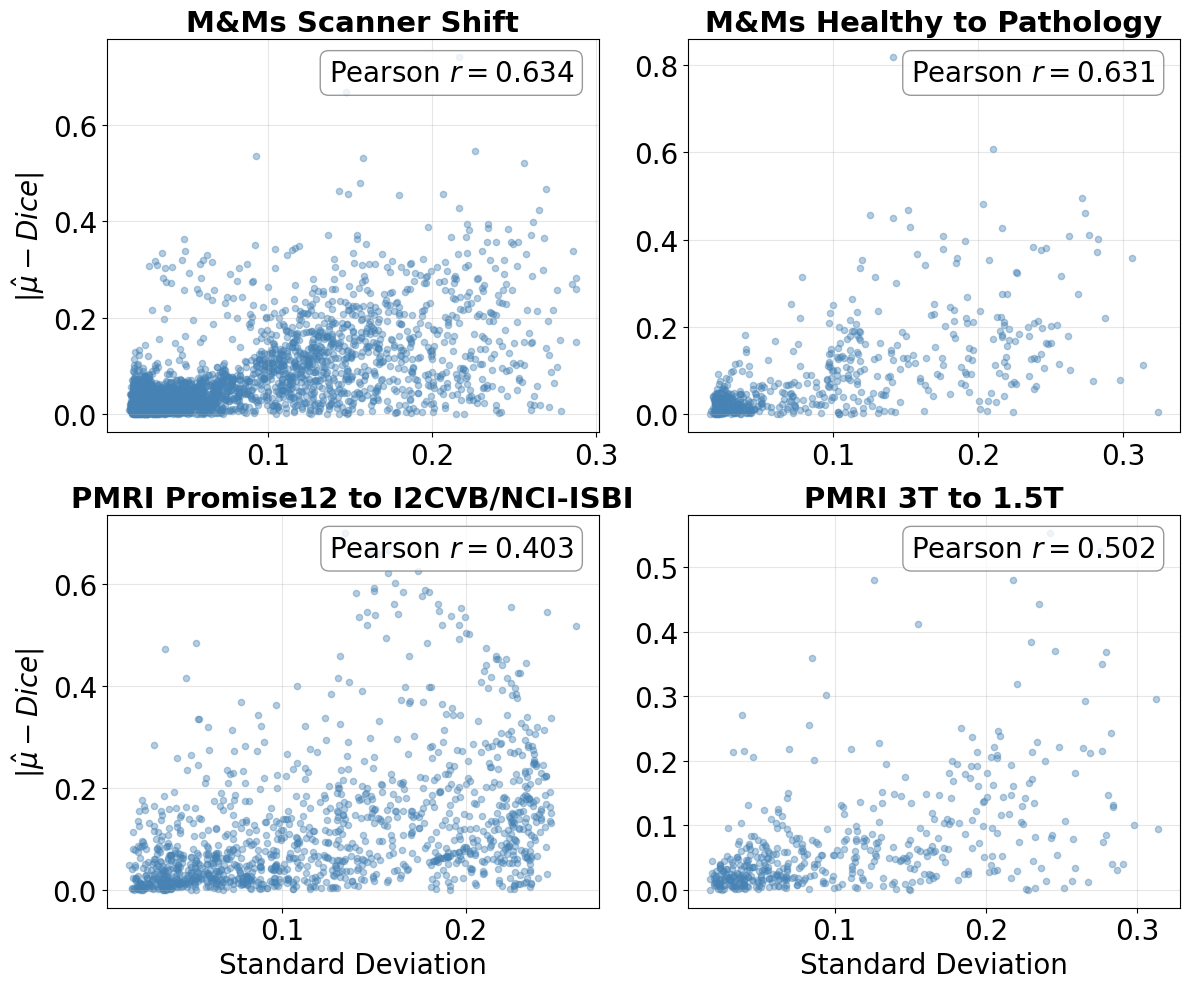

In [19]:
# Kappa vs Prediction Error Analysis
# For beta methods: analyze correlation between concentration (kappa) and prediction error
# 2x2 plot layout, one subplot per dataset/split
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr

print("="*100)
print("KAPPA (CONCENTRATION) VS PREDICTION ERROR ANALYSIS")
print("="*100)

# Configuration
FONT_SIZE = 20

# Select a beta method to analyze (use location+concentration_beta)
selected_method = 'location+concentration_beta'

# Dataset display names (matching the recall plot)
DATASET_NAMES = {
    'mnmv2_scanner-symphonytim': 'M&Ms Scanner Shift',
    'mnmv2_pathology-norm-vs-fall-scanners-all': 'M&Ms Healthy to Pathology',
    'pmri_threet-to-onepointfivet': 'PMRI 3T to 1.5T',
    'pmri_promise12': 'PMRI Promise12 to I2CVB/NCI-ISBI'
}

# Collect data for 2x2 subplot (2 datasets × 2 splits each)
plot_data = {}

for dataset_id in sorted(data_cache.keys()):
    for split_id in sorted(data_cache[dataset_id].keys()):
        # Find the selected method for this split
        method_found = None
        for label, cached_data in data_cache[dataset_id][split_id].items():
            if selected_method in label:
                method_found = label
                break
        
        if not method_found:
            continue
        
        cached_data = data_cache[dataset_id][split_id][method_found]
        payload = cached_data['payload']
        test_data = payload['sections']['test']
        
        # Check if this is a beta method with kappa
        if 'kappa' not in test_data:
            print(f"{dataset_id} - {split_id}: No kappa found, skipping")
            continue
        
        # Get predictions and ground truth
        y_pred = test_data['predicted_score']
        y_true = test_data['true_score']
        
        if y_pred.dim() > 1:
            y_pred = y_pred.squeeze(-1)
        if y_true.dim() > 1:
            y_true = y_true.squeeze(-1)
        
        # Get kappa (concentration parameter) and mu (location parameter)
        kappa = test_data['kappa']
        mu = test_data['mu']
        if kappa.size(1) > 1:
            kappa = kappa[:, 0]
        if mu.size(1) > 1:
            mu = mu[:, 0]
        if kappa.dim() > 1:
            kappa = kappa.squeeze(-1)
        if mu.dim() > 1:
            mu = mu.squeeze(-1)
        
        # Compute standard deviation of beta distribution: sqrt(mu * (1 - mu) / (kappa + 1))
        beta_std = torch.sqrt(mu * (1 - mu) / (kappa + 1))
        
        # Compute prediction error (offset)
        prediction_error = torch.abs(y_pred - y_true)
        
        # Convert to numpy
        beta_std_np = beta_std.cpu().numpy() if torch.is_tensor(beta_std) else beta_std
        error_np = prediction_error.cpu().numpy() if torch.is_tensor(prediction_error) else prediction_error
        
        # Compute correlations
        pearson_r, pearson_p = pearsonr(beta_std_np, error_np)
        spearman_r, spearman_p = spearmanr(beta_std_np, error_np)
        
        plot_key = f"{dataset_id}_{split_id}"
        plot_data[plot_key] = {
            'dataset': dataset_id,
            'split': split_id,
            'beta_std': beta_std_np,
            'error': error_np,
            'pearson_r': pearson_r,
            'pearson_p': pearson_p,
            'spearman_r': spearman_r,
            'spearman_p': spearman_p,
            'method': method_found
        }
        
        print(f"{dataset_id} - {split_id}: Pearson r={pearson_r:.4f} (p={pearson_p:.4e}), "
              f"Spearman ρ={spearman_r:.4f} (p={spearman_p:.4e})")

# Create 2x2 plot layout
if len(plot_data) > 0:
    n_cols = 2
    n_rows = 2
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 10))
    axes = axes.flatten()
    
    # Custom plot order: scanner left, pathology right
    plot_order = [
        'mnmv2_scanner-symphonytim',                   # Top left
        'mnmv2_pathology-norm-vs-fall-scanners-all',  # Top right
        'pmri_promise12',                               # Bottom left
        'pmri_threet-to-onepointfivet'                 # Bottom right
    ]
    
    for idx, plot_key in enumerate(plot_order):
        if plot_key not in plot_data or idx >= len(axes):
            continue
        
        ax = axes[idx]
        data = plot_data[plot_key]
        
        # Scatter plot (beta standard deviation on x-axis, error on y-axis)
        ax.scatter(data['beta_std'], data['error'], alpha=0.4, s=20, color='steelblue')
        
        # Get display name for title
        display_name = DATASET_NAMES.get(plot_key, f"{data['dataset'].upper()} - {data['split']}")
        
        # Styling
        # Remove x-axis label for top plots (idx 0, 1)
        if idx >= 2:
            ax.set_xlabel(r'Standard Deviation', fontsize=FONT_SIZE)
        
        # Remove y-axis label for right plots (idx 1, 3)
        if idx % 2 == 0:
            ax.set_ylabel(r'$|\hat{\mu} - Dice|$', fontsize=FONT_SIZE)
        
        ax.set_title(display_name, fontsize=FONT_SIZE+1, fontweight='bold')
        ax.grid(True, alpha=0.3)
        
        # Set tick label sizes
        ax.tick_params(axis='both', which='major', labelsize=FONT_SIZE)
        
        # Add Pearson correlation text box inside the plot (top right)
        pearson_text = f"Pearson $r={data['pearson_r']:.3f}$"
        ax.text(0.95, 0.95, pearson_text, transform=ax.transAxes,
               fontsize=FONT_SIZE, verticalalignment='top', horizontalalignment='right',
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor='gray'))
    
    # Hide unused subplots
    for idx in range(len(plot_order), len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.savefig(f'../../results/beta_std_vs_prediction_error_{selected_method}.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("\nNo data found for selected method with kappa parameter!")
    print(f"Selected method: {selected_method}")

